In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Set a seed for reproducibility
seed_value = 42
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

## Data Loading

In [3]:
df_bank_a = pd.read_csv('../data/BankA_preprocessed.csv')
df_bank_b = pd.read_csv('../data/BankB_preprocessed.csv')
df_bank_c = pd.read_csv('../data/BankC_preprocessed.csv')

In [4]:
df_all = pd.concat([df_bank_a, df_bank_b, df_bank_c])

## Data Preprocessing

### Create bins for age

In [5]:
# Convert age in bins of 10 years
df_all['age'] = pd.cut(df_all['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_a['age'] = pd.cut(df_bank_a['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_b['age'] = pd.cut(df_bank_b['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_c['age'] = pd.cut(df_bank_c['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])

In [6]:
df_all.head()

,age,workclass,education,marital-status,occupation,relationship,hours-per-week,native-country,income,capital-diff
0,30-40,Private,Bachelors,Married,high,Parent,50,North-America,1,7298
1,40-50,Private,Bachelors,Married,medium,Parent,55,North-America,1,0
2,50-60,unknown,Bachelors,Married-spouse-absent,unknown,Other-relative,15,North-America,0,0
3,30-40,Private,Bachelors,Married,medium,Parent,40,North-America,0,0
4,60-70,Self-emp-inc,Bachelors,Married,medium,Parent,40,North-America,1,15024


### Target Column

In [7]:
# One-hot encode the categorical columns
categorical_columns = df_all.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_all = pd.get_dummies(df_all, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_a.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_a = pd.get_dummies(df_bank_a, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_b.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_b = pd.get_dummies(df_bank_b, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_c.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_c = pd.get_dummies(df_bank_c, columns=categorical_columns)

## Model Training

### Data Splitting for Training and Testing

In [8]:
# number of rows in each dataset
print(f"Number of rows in df_all:    {len(df_all)}")
print(f"Number of rows in df_bank_a: {len(df_bank_a)}")
print(f"Number of rows in df_bank_b: {len(df_bank_b)}")
print(f"Number of rows in df_bank_c: {len(df_bank_c)}")

Number of rows in df_all:    799999
Number of rows in df_bank_a: 226164
Number of rows in df_bank_b: 403240
Number of rows in df_bank_c: 170595


In [9]:
# Create a test set that contains 20% of the data from each bank
df_bank_a_test = df_bank_a.sample(frac=0.2, random_state=seed_value)
df_bank_b_test = df_bank_b.sample(frac=0.2, random_state=seed_value)
df_bank_c_test = df_bank_c.sample(frac=0.2, random_state=seed_value)

# Create a training set that contains the remaining 80% of the data from each bank
df_bank_a_train = df_bank_a.drop(df_bank_a_test.index)
df_bank_b_train = df_bank_b.drop(df_bank_b_test.index)
df_bank_c_train = df_bank_c.drop(df_bank_c_test.index)

# Combine the training sets into one training set
df_train = pd.concat([df_bank_a_train, df_bank_b_train, df_bank_c_train])

# Combine the test sets into one test set
df_test = pd.concat([df_bank_a_test, df_bank_b_test, df_bank_c_test])

In [10]:
# Split the training and test sets into X and y
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']

X_train_bank_a = df_bank_a_train.drop('income', axis=1)
y_train_bank_a = df_bank_a_train['income']
X_test_bank_a = df_bank_a_test.drop('income', axis=1)
y_test_bank_a = df_bank_a_test['income']

X_train_bank_b = df_bank_b_train.drop('income', axis=1)
y_train_bank_b = df_bank_b_train['income']
X_test_bank_b = df_bank_b_test.drop('income', axis=1)
y_test_bank_b = df_bank_b_test['income']

X_train_bank_c = df_bank_c_train.drop('income', axis=1)
y_train_bank_c = df_bank_c_train['income']
X_test_bank_c = df_bank_c_test.drop('income', axis=1)
y_test_bank_c = df_bank_c_test['income']

### Model Training

#### Finding good hyperparameters for different models

In [10]:
# Find the best hyperparameters for a decision tree classifier

# Create a decision tree classifier
clf_dt = DecisionTreeClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

grid_search_dt = RandomizedSearchCV(estimator=clf_dt, n_iter=15, param_distributions=param_grid_dt, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_dt.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)
print(grid_search_dt.best_estimator_)

{'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 14, 'max_depth': 14, 'criterion': 'entropy'}
0.8448341384747147
DecisionTreeClassifier(criterion='entropy', max_depth=14, max_features=14,
                       min_samples_leaf=14, min_samples_split=8,
                       random_state=42)


In [24]:
# Find the best hyperparameters for a logistic regression classifier

# Create a logistic regression classifier
clf_lr = LogisticRegression(random_state=seed_value)

# Define the grid search parameters
param_grid_lg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000],
}

grid_search_lg = RandomizedSearchCV(estimator=clf_lr, n_iter=15, param_distributions=param_grid_lg, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_lg.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_lg.best_params_)
print(grid_search_lg.best_score_)
print(grid_search_lg.best_estimator_)

/home/leowe/git-projects/FHSTP_FML_assignment2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leowe/git-projects/FHSTP_FML_assignment2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leowe/git-projects/FHSTP_FML_assignment2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leowe/git-projects/FHSTP_FML_assignment2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leowe/git-projects/FHSTP_FML_assignment2/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
0.8368231845683365
LogisticRegression(C=0.001, max_iter=2000, random_state=42, solver='liblinear')


In [25]:
# Find the best hyperparameters for a random forest classifier

# Create a random forest classifier
clf_rf = RandomForestClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_rf = {
    'n_estimators': [3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 10, 12, 14, 16, 32],
    'min_samples_split': [10, 32, 128, 256, 512, 1024],
    'min_samples_leaf': [16, 32, 64, 128, 256],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

grid_search_rf = RandomizedSearchCV(estimator=clf_rf, n_iter=15, param_distributions=param_grid_rf, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)
print(grid_search_rf.best_estimator_)

{'n_estimators': 5, 'min_samples_split': 128, 'min_samples_leaf': 16, 'max_features': 16, 'max_depth': 12, 'criterion': 'entropy'}
0.8488435197125563
RandomForestClassifier(criterion='entropy', max_depth=12, max_features=16,
                       min_samples_leaf=16, min_samples_split=128,
                       n_estimators=5, random_state=42)


In [26]:
# Find the best hyperparameters for a gradient boosting classifier

# Create a gradient boosting classifier
clf_gb = GradientBoostingClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_gb = {
    'n_estimators': [3, 9, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_depth': [2, 4, 6, 8, 10, 12, 36],
    'min_samples_split': [10, 12, 14, 16, 32, 128],
    'min_samples_leaf': [16, 32, 64, 128, 256],
    'max_features': [2, 4, 6, 8, 16, 20, 32]
}

grid_search_gb = RandomizedSearchCV(estimator=clf_gb, n_iter=15, param_distributions=param_grid_gb, cv=5, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_gb.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)

{'n_estimators': 200, 'min_samples_split': 128, 'min_samples_leaf': 16, 'max_features': 6, 'max_depth': 2, 'learning_rate': 1}
0.8517357181867631
GradientBoostingClassifier(learning_rate=1, max_depth=2, max_features=6,
                           min_samples_leaf=16, min_samples_split=128,
                           n_estimators=200, random_state=42)


#### Train a model with all data from all banks

In [27]:
# Define and Train the models with the best hyperparameters
model_global_dt = clone(grid_search_dt.best_estimator_).fit(X_train, y_train)
model_global_lg = clone(grid_search_lg.best_estimator_).fit(X_train, y_train)
model_global_rf = clone(grid_search_rf.best_estimator_).fit(X_train, y_train)
model_global_gb = clone(grid_search_gb.best_estimator_).fit(X_train, y_train)

model_bank_a_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_a, y_train_bank_a)

model_bank_b_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_b, y_train_bank_b)

model_bank_c_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_c, y_train_bank_c)

In [32]:
# Export the trained models
joblib.dump(model_global_dt, './models/model_global_dt.pkl')
joblib.dump(model_global_lg, './models/model_global_lg.pkl')
joblib.dump(model_global_rf, './models/model_global_rf.pkl')
joblib.dump(model_global_gb, './models/model_global_gb.pkl')

joblib.dump(model_bank_a_dt, './models/model_bank_a_dt.pkl')
joblib.dump(model_bank_a_lg, './models/model_bank_a_lg.pkl')
joblib.dump(model_bank_a_rf, './models/model_bank_a_rf.pkl')
joblib.dump(model_bank_a_gb, './models/model_bank_a_gb.pkl')

joblib.dump(model_bank_b_dt, './models/model_bank_b_dt.pkl')
joblib.dump(model_bank_b_lg, './models/model_bank_b_lg.pkl')
joblib.dump(model_bank_b_rf, './models/model_bank_b_rf.pkl')
joblib.dump(model_bank_b_gb, './models/model_bank_b_gb.pkl')

joblib.dump(model_bank_c_dt, './models/model_bank_c_dt.pkl')
joblib.dump(model_bank_c_lg, './models/model_bank_c_lg.pkl')
joblib.dump(model_bank_c_rf, './models/model_bank_c_rf.pkl')
joblib.dump(model_bank_c_gb, './models/model_bank_c_gb.pkl')

['./models/model_bank_c_gb.pkl']

#### Evaluate all the models

In [28]:
# Evaluate the global models on the global test set

## Predict
y_pred_global_global_dt = model_global_dt.predict(X_test)
y_pred_global_global_lg = model_global_lg.predict(X_test)
y_pred_global_global_rf = model_global_rf.predict(X_test)
y_pred_global_global_gb = model_global_gb.predict(X_test)
## Metrics
acc_global_global_dt = accuracy_score(y_test, y_pred_global_global_dt)
acc_global_global_lg = accuracy_score(y_test, y_pred_global_global_lg)
acc_global_global_rf = accuracy_score(y_test, y_pred_global_global_rf)
acc_global_global_gb = accuracy_score(y_test, y_pred_global_global_gb)
f1_global_global_dt = f1_score(y_test, y_pred_global_global_dt)
f1_global_global_lg = f1_score(y_test, y_pred_global_global_lg)
f1_global_global_rf = f1_score(y_test, y_pred_global_global_rf)
f1_global_global_gb = f1_score(y_test, y_pred_global_global_gb)
kappa_global_global_dt = cohen_kappa_score(y_test, y_pred_global_global_dt)
kappa_global_global_lg = cohen_kappa_score(y_test, y_pred_global_global_lg)
kappa_global_global_rf = cohen_kappa_score(y_test, y_pred_global_global_rf)
kappa_global_global_gb = cohen_kappa_score(y_test, y_pred_global_global_gb)


# Evaluate the global models on the bank A, B and C test sets
## Predict
y_pred_global_bank_a_dt = model_global_dt.predict(X_test_bank_a)
y_pred_global_bank_a_lg = model_global_lg.predict(X_test_bank_a)
y_pred_global_bank_a_rf = model_global_rf.predict(X_test_bank_a)
y_pred_global_bank_a_gb = model_global_gb.predict(X_test_bank_a)

y_pred_global_bank_b_dt = model_global_dt.predict(X_test_bank_b)
y_pred_global_bank_b_lg = model_global_lg.predict(X_test_bank_b)
y_pred_global_bank_b_rf = model_global_rf.predict(X_test_bank_b)
y_pred_global_bank_b_gb = model_global_gb.predict(X_test_bank_b)

y_pred_global_bank_c_dt = model_global_dt.predict(X_test_bank_c)
y_pred_global_bank_c_lg = model_global_lg.predict(X_test_bank_c)
y_pred_global_bank_c_rf = model_global_rf.predict(X_test_bank_c)
y_pred_global_bank_c_gb = model_global_gb.predict(X_test_bank_c)
## Metrics
acc_global_bank_a_dt = accuracy_score(y_test_bank_a, y_pred_global_bank_a_dt)
acc_global_bank_a_lg = accuracy_score(y_test_bank_a, y_pred_global_bank_a_lg)
acc_global_bank_a_rf = accuracy_score(y_test_bank_a, y_pred_global_bank_a_rf)
acc_global_bank_a_gb = accuracy_score(y_test_bank_a, y_pred_global_bank_a_gb)
f1_global_bank_a_dt = f1_score(y_test_bank_a, y_pred_global_bank_a_dt)
f1_global_bank_a_lg = f1_score(y_test_bank_a, y_pred_global_bank_a_lg)
f1_global_bank_a_rf = f1_score(y_test_bank_a, y_pred_global_bank_a_rf)
f1_global_bank_a_gb = f1_score(y_test_bank_a, y_pred_global_bank_a_gb)
kappa_global_bank_a_dt = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_dt)
kappa_global_bank_a_lg = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_lg)
kappa_global_bank_a_rf = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_rf)
kappa_global_bank_a_gb = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_gb)

acc_global_bank_b_dt = accuracy_score(y_test_bank_b, y_pred_global_bank_b_dt)
acc_global_bank_b_lg = accuracy_score(y_test_bank_b, y_pred_global_bank_b_lg)
acc_global_bank_b_rf = accuracy_score(y_test_bank_b, y_pred_global_bank_b_rf)
acc_global_bank_b_gb = accuracy_score(y_test_bank_b, y_pred_global_bank_b_gb)
f1_global_bank_b_dt = f1_score(y_test_bank_b, y_pred_global_bank_b_dt)
f1_global_bank_b_lg = f1_score(y_test_bank_b, y_pred_global_bank_b_lg)
f1_global_bank_b_rf = f1_score(y_test_bank_b, y_pred_global_bank_b_rf)
f1_global_bank_b_gb = f1_score(y_test_bank_b, y_pred_global_bank_b_gb)
kappa_global_bank_b_dt = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_dt)
kappa_global_bank_b_lg = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_lg)
kappa_global_bank_b_rf = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_rf)
kappa_global_bank_b_gb = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_gb)

acc_global_bank_c_dt = accuracy_score(y_test_bank_c, y_pred_global_bank_c_dt)
acc_global_bank_c_lg = accuracy_score(y_test_bank_c, y_pred_global_bank_c_lg)
acc_global_bank_c_rf = accuracy_score(y_test_bank_c, y_pred_global_bank_c_rf)
acc_global_bank_c_gb = accuracy_score(y_test_bank_c, y_pred_global_bank_c_gb)
f1_global_bank_c_dt = f1_score(y_test_bank_c, y_pred_global_bank_c_dt)
f1_global_bank_c_lg = f1_score(y_test_bank_c, y_pred_global_bank_c_lg)
f1_global_bank_c_rf = f1_score(y_test_bank_c, y_pred_global_bank_c_rf)
f1_global_bank_c_gb = f1_score(y_test_bank_c, y_pred_global_bank_c_gb)
kappa_global_bank_c_dt = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_dt)
kappa_global_bank_c_lg = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_lg)
kappa_global_bank_c_rf = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_rf)
kappa_global_bank_c_gb = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_gb)


# Evaluate the bank A models on the bank A test set
## Predict
y_pred_bank_a_bank_a_dt = model_bank_a_dt.predict(X_test_bank_a)
y_pred_bank_a_bank_a_lg = model_bank_a_lg.predict(X_test_bank_a)
y_pred_bank_a_bank_a_rf = model_bank_a_rf.predict(X_test_bank_a)
y_pred_bank_a_bank_a_gb = model_bank_a_gb.predict(X_test_bank_a)
## Metrics
acc_bank_a_bank_a_dt = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
acc_bank_a_bank_a_lg = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
acc_bank_a_bank_a_rf = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
acc_bank_a_bank_a_gb = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
f1_bank_a_bank_a_dt = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
f1_bank_a_bank_a_lg = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
f1_bank_a_bank_a_rf = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
f1_bank_a_bank_a_gb = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
kappa_bank_a_bank_a_dt = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
kappa_bank_a_bank_a_lg = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
kappa_bank_a_bank_a_rf = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
kappa_bank_a_bank_a_gb = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)


# Evaluate the bank B models on the bank B test set
## Predict
y_pred_bank_b_bank_b_dt = model_bank_b_dt.predict(X_test_bank_b)
y_pred_bank_b_bank_b_lg = model_bank_b_lg.predict(X_test_bank_b)
y_pred_bank_b_bank_b_rf = model_bank_b_rf.predict(X_test_bank_b)
y_pred_bank_b_bank_b_gb = model_bank_b_gb.predict(X_test_bank_b)
## Metrics
acc_bank_b_bank_b_dt = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
acc_bank_b_bank_b_lg = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
acc_bank_b_bank_b_rf = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
acc_bank_b_bank_b_gb = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
f1_bank_b_bank_b_dt = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
f1_bank_b_bank_b_lg = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
f1_bank_b_bank_b_rf = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
f1_bank_b_bank_b_gb = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
kappa_bank_b_bank_b_dt = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
kappa_bank_b_bank_b_lg = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
kappa_bank_b_bank_b_rf = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
kappa_bank_b_bank_b_gb = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)


# Evaluate the bank C models on the bank C test set
## Predict
y_pred_bank_c_bank_c_dt = model_bank_c_dt.predict(X_test_bank_c)
y_pred_bank_c_bank_c_lg = model_bank_c_lg.predict(X_test_bank_c)
y_pred_bank_c_bank_c_rf = model_bank_c_rf.predict(X_test_bank_c)
y_pred_bank_c_bank_c_gb = model_bank_c_gb.predict(X_test_bank_c)
## Metrics
acc_bank_c_bank_c_dt = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
acc_bank_c_bank_c_lg = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
acc_bank_c_bank_c_rf = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
acc_bank_c_bank_c_gb = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
f1_bank_c_bank_c_dt = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
f1_bank_c_bank_c_lg = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
f1_bank_c_bank_c_rf = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
f1_bank_c_bank_c_gb = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
kappa_bank_c_bank_c_dt = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
kappa_bank_c_bank_c_lg = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
kappa_bank_c_bank_c_rf = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
kappa_bank_c_bank_c_gb = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)

In [29]:
# Store all metrics in a dataframe with columns: modeltype, explainability, model, dataset , accuracy, f1, kappa
df_metrics = pd.DataFrame(columns=['modeltype', 'explainability', 'model', 'dataset', 'accuracy', 'f1', 'kappa'])

# Add the global models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_dt, 'f1': f1_global_global_dt, 'kappa': kappa_global_global_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_lg, 'f1': f1_global_global_lg, 'kappa': kappa_global_global_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_rf, 'f1': f1_global_global_rf, 'kappa': kappa_global_global_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'global dataset', 'accuracy': acc_global_global_gb, 'f1': f1_global_global_gb, 'kappa': kappa_global_global_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_dt, 'f1': f1_global_bank_a_dt, 'kappa': kappa_global_bank_a_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_lg, 'f1': f1_global_bank_a_lg, 'kappa': kappa_global_bank_a_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_rf, 'f1': f1_global_bank_a_rf, 'kappa': kappa_global_bank_a_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_gb, 'f1': f1_global_bank_a_gb, 'kappa': kappa_global_bank_a_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_dt, 'f1': f1_global_bank_b_dt, 'kappa': kappa_global_bank_b_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_lg, 'f1': f1_global_bank_b_lg, 'kappa': kappa_global_bank_b_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_rf, 'f1': f1_global_bank_b_rf, 'kappa': kappa_global_bank_b_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_gb, 'f1': f1_global_bank_b_gb, 'kappa': kappa_global_bank_b_gb}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_dt, 'f1': f1_global_bank_c_dt, 'kappa': kappa_global_bank_c_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_lg, 'f1': f1_global_bank_c_lg, 'kappa': kappa_global_bank_c_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_rf, 'f1': f1_global_bank_c_rf, 'kappa': kappa_global_bank_c_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'global model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_gb, 'f1': f1_global_bank_c_gb, 'kappa': kappa_global_bank_c_gb}, index=[0])], ignore_index=True)

# Add the bank A models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_dt, 'f1': f1_bank_a_bank_a_dt, 'kappa': kappa_bank_a_bank_a_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_lg, 'f1': f1_bank_a_bank_a_lg, 'kappa': kappa_bank_a_bank_a_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_rf, 'f1': f1_bank_a_bank_a_rf, 'kappa': kappa_bank_a_bank_a_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'bank A model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_gb, 'f1': f1_bank_a_bank_a_gb, 'kappa': kappa_bank_a_bank_a_gb}, index=[0])], ignore_index=True)

# Add the bank B models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_dt, 'f1': f1_bank_b_bank_b_dt, 'kappa': kappa_bank_b_bank_b_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_lg, 'f1': f1_bank_b_bank_b_lg, 'kappa': kappa_bank_b_bank_b_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_rf, 'f1': f1_bank_b_bank_b_rf, 'kappa': kappa_bank_b_bank_b_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'bank B model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_gb, 'f1': f1_bank_b_bank_b_gb, 'kappa': kappa_bank_b_bank_b_gb}, index=[0])], ignore_index=True)

# Add the bank C models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_dt, 'f1': f1_bank_c_bank_c_dt, 'kappa': kappa_bank_c_bank_c_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_lg, 'f1': f1_bank_c_bank_c_lg, 'kappa': kappa_bank_c_bank_c_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_rf, 'f1': f1_bank_c_bank_c_rf, 'kappa': kappa_bank_c_bank_c_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'bank C model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_gb, 'f1': f1_bank_c_bank_c_gb, 'kappa': kappa_bank_c_bank_c_gb}, index=[0])], ignore_index=True)

In [33]:
# Rename dataset to testdataset
df_metrics = df_metrics.rename(columns={'dataset': 'testdataset'})

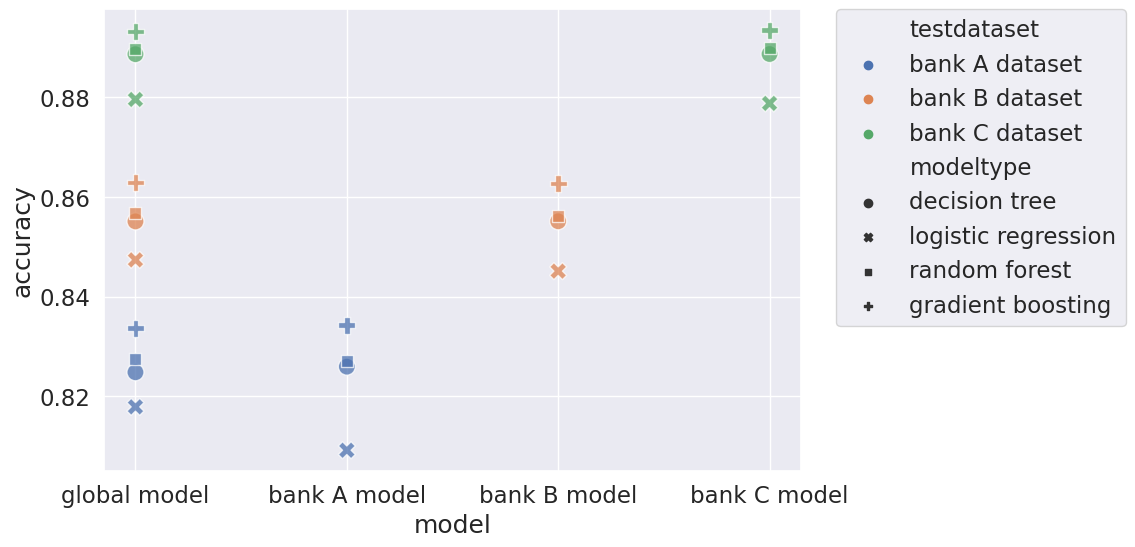

In [35]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.set(font_scale=1.5)
ax = sns.scatterplot(x="model", y="accuracy", hue="testdataset", style="modeltype", data=df_metrics[df_metrics['testdataset'] != 'global dataset'], s=150, alpha=0.75)
ax.set(xlabel='model', ylabel='accuracy')
# Rename the legend titles
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# FML

In [46]:
import json
import flwr as fl

from xgboost import XGBClassifier
from pathlib import Path

tmp_path = Path("")

In [39]:
def get_parameters( model ):
    tmp_model = Path( tmp_path / 'model_tmp_prms.json' )
    model.get_booster().save_model( tmp_model )
    with open( tmp_model, 'r' ) as fr:
        params = json.load( fr )
    return [ params ]

def model_from_paramaters( parameters ):
    tmp_model = Path( tmp_path / 'model_tmp_fit.json' )
    with open( tmp_model, 'w' ) as fw:
        json.dump( parameters, fw )
    model = XGBClassifier()
    model.load_model( tmp_model )
    return model

In [40]:
class XGBoostClient( fl.client.NumPyClient ):
    def __init__( self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test

    def get_parameters( self, config ):
        return get_parameters( self.model )

    def fit( self, parameters, config ):
        self.model = model_from_paramaters( parameters )
        loss = log_loss( self.y_train, self.model.predict_proba( self.X_train ) )
        self.model.fit( self.X_train, self.y_train )
        return (
            get_parameters( self.model ),
            len( self.X_train ),
            { 'loss': float( loss ) },
        )

    def evaluate( self, parameters, config ):
        self.model = model_from_paramaters( parameters )
        loss = log_loss( self.y_test, self.model.predict_proba( self.X_test ) )
        accuracy = float( self.model.score( self.X_test, self.y_test ) )
        return float( loss ), len( self.X_test ), { 'loss': float(loss), 'accuracy': accuracy }

In [43]:
model = XGBClassifier(
     learning_rate    = 0.1,
     min_child_weight = 1,
     gamma            = 1,
     subsample        = 0.8,
     colsample_bytree = 0.6,
     max_depth        = 4
)

In [44]:
client = XGBoostClient(model, X_train, y_train, X_test, y_test)

In [45]:
client.model.fit(X_train, y_train) # train model
accuracy = client.model.score(X_test, y_test) # scores

In [33]:
from pathlib import Path
import json
tmp_path = Path("")

In [34]:
def get_evaluate_fn( model, X_test, y_test ):
    def evaluate( server_round, parameters ):
        model = model_from_paramaters( parameters )
        y_pred = model.predict( X_test )
        loss = log_loss( y_test, y_pred )
        accuracy = model.score( X_test, y_test )
        return loss, { 'accuracy': accuracy }
    return evaluate

def model_from_paramaters( parameters ):
    parameters = json.loads( str( parameters.tensors, 'utf-8' ) )
    tmp_model = Path( tmp_path ) / 'model_tmp_fit.json'
    with open( tmp_model, 'w' ) as fw:
        json.dump( parameters, fw )
    model = XGBClassifier()
    model.load_model( tmp_model )
    return model

def evaluate_for_xgb( self, server_round, parameters ):
    eval_res = self.evaluate_fn( server_round, parameters ) 
    if eval_res is None:
        return None
    loss, metrics = eval_res
    return loss, metrics

def get_parameters( model ):
    class ParamWrap( dict ): # Wrapper to propagate the json-like definition of the model
        def __init__( self, params ):
            dict.__init__( self )
            self.tensors = json.dumps( params ).encode( 'utf-8' ) 
            self.tensor_type = ''
            self.parameters = json.dumps( params ).encode( 'utf-8' ) 
            self.config = {}

    tmp_model = Path( tmp_path ) / 'model_tmp_prms.json'
    model.get_booster().save_model( tmp_model )
    with open( tmp_model, 'r' ) as fr:
        params = json.load( fr )

    return ParamWrap( params )
    

In [35]:
fit_round = 2
parameters = get_parameters( model )

In [36]:
strategy = fl.server.strategy.FedAvg(
    evaluate_fn        = get_evaluate_fn( model, X_test, y_test ),
    on_fit_config_fn   = fit_round,
    initial_parameters = parameters
)

In [ ]:
result = fl.simulation.start_simulation(
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_fn= lambda i: client_models[int(i)], #client_fn,
)